In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 10

In [5]:
seed = 3121
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  W9TG7ZON_05_26_25
NN-MODEL FILENAME:  ./models/W9TG7ZON_05_26_25_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
TERMINAL_BIAS       = 0.5   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 300000

In [11]:
MAX_NO_OF_ITERATIONS = 30
MAX_NN_ITERATIONS    = 15000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  30


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.4
C_POS_ABS_MIN = -2.4

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################


    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = node_q_table

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration+1)*0.15) ,0.3,0.97)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
        
    my_LR        = T_LR
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state][:].argmax()

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))

                # learn
#                 my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - my_Q_TABLE[this_state][a])
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, -1).astype(np.float16)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1265.46 MiB, increment: 1045.70 MiB
Quantization TIME:  0.01 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
SMALLEST TIMESTEP in ITERATION 0: 9
REAL TIME TO GENERATE 22670 EXPERIENCES:0:00:00.652046


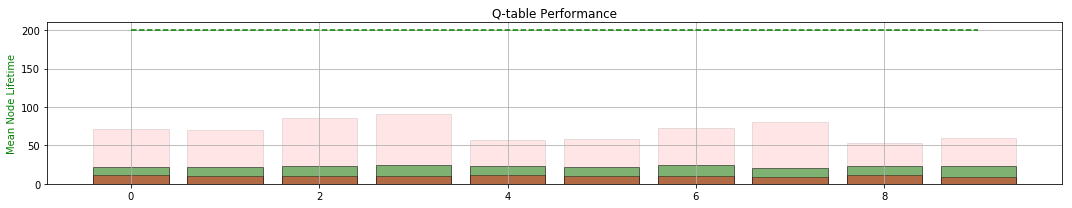

MEMORY COUNTER:  22670
Training Neural Network for 15000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 4.408	LOSS : 5.206	LOSS : 5.032	LOSS : 4.934	LOSS : 5.287	LOSS : 4.376	LOSS : 5.244	LOSS : 4.312	LOSS : 4.233	LOSS : 4.401	LOSS : 4.600	LOSS : 4.435	LOSS : 4.861	LOSS : 4.296	LOSS : 4.639	LOSS : 4.419	LOSS : 3.940	LOSS : 4.326	LOSS : 3.750	LOSS : 4.031	LOSS : 4.251	LOSS : 4.337	LOSS : 3.763	LOSS : 4.522	LOSS : 4.357	LOSS : 4.057	LOSS : 4.408	LOSS : 4.421	LOSS : 4.372	LOSS : 4.253	
Validating... MEAN TIME:  194.625
LOSS : 4.119	LOSS : 4.017	LOSS : 4.406	LOSS : 3.998	LOSS : 4.224	LOSS : 4.377	LOSS : 4.403	LOSS : 4.115	LOSS : 4.177	LOSS : 4.181	LOSS : 4.363	LOSS : 4.228	LOSS : 4.037	LOSS : 4.096	LOSS : 4.075	LOSS : 4.078	LOSS : 4.252	LOSS : 4.280	LOSS : 3.818	LOSS : 4.511	LOSS : 4.234	LOSS : 4.507	LOSS : 4.267	LOSS : 4.095	LOSS : 4.060	LOSS : 3.965	LOSS : 4.133	LOSS : 4.113	LOSS : 4.055	LOSS : 4.110	
Validating... MEAN TIME:  199.665
LOSS : 4.027	LOSS : 3

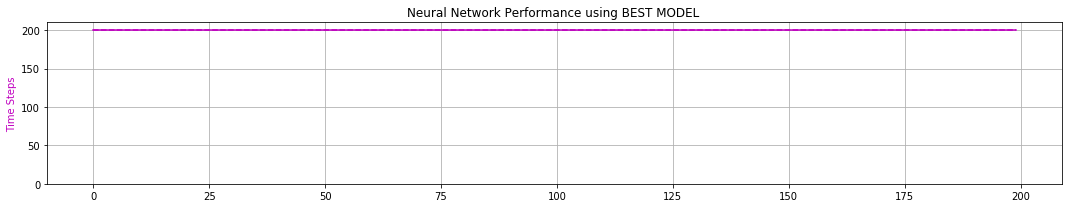

peak memory: 1347.01 MiB, increment: 1045.19 MiB
0 -max- [ 0.221  1.224  0.209  2.183]
0 -min- [-0.097 -1.386 -0.209 -2.108]

1 -max- [ 0.182  1.215  0.208  1.443]
1 -min- [-0.113 -0.995 -0.209 -2.004]

2 -max- [ 0.209  1.173  0.209  1.633]
2 -min- [-0.048 -0.946 -0.209 -1.801]

3 -max- [ 0.192  1.354  0.209  1.598]
3 -min- [-0.086 -0.928 -0.209 -2.150]

4 -max- [ 0.204  1.527  0.202  1.775]
4 -min- [-0.076 -0.815 -0.209 -2.427]

5 -max- [ 0.195  1.229  0.206  1.762]
5 -min- [-0.072 -0.975 -0.209 -2.175]

6 -max- [ 0.211  1.384  0.208  2.141]
6 -min- [-0.050 -1.119 -0.209 -2.232]

7 -max- [ 0.190  1.373  0.198  1.424]
7 -min- [-0.051 -0.763 -0.209 -2.233]

8 -max- [ 0.193  1.152  0.208  1.725]
8 -min- [-0.091 -1.152 -0.209 -1.806]

9 -max- [ 0.196  1.347  0.209  1.793]
9 -min- [-0.125 -0.961 -0.209 -2.061]

Quantization TIME:  0.02 minutes


ITERATION # 1
SMALLEST TIMESTEP in ITERATION 1: 9
REAL TIME TO GENERATE 68361 EXPERIENCES:0:00:01.821797


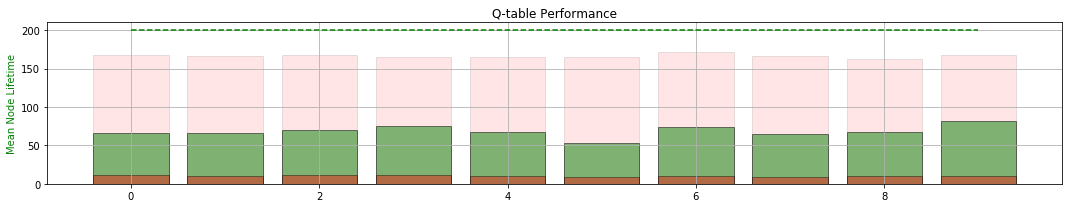

MEMORY COUNTER:  91031
Training Neural Network for 15000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 4.058	LOSS : 3.485	LOSS : 3.467	LOSS : 3.947	LOSS : 3.372	LOSS : 3.232	LOSS : 3.508	LOSS : 3.518	LOSS : 3.498	LOSS : 3.127	LOSS : 2.970	LOSS : 3.140	LOSS : 3.013	LOSS : 3.127	LOSS : 2.988	LOSS : 3.477	LOSS : 3.136	LOSS : 2.894	LOSS : 2.950	LOSS : 3.079	LOSS : 2.696	LOSS : 3.156	LOSS : 3.176	LOSS : 2.972	LOSS : 3.152	LOSS : 2.993	LOSS : 2.777	LOSS : 2.868	LOSS : 2.900	LOSS : 3.006	
Validating... MEAN TIME:  174.345
LOSS : 2.931	LOSS : 2.640	LOSS : 2.407	LOSS : 2.724	LOSS : 2.453	LOSS : 2.763	LOSS : 2.310	LOSS : 2.884	LOSS : 2.872	LOSS : 2.598	LOSS : 2.745	LOSS : 2.569	LOSS : 2.473	LOSS : 2.340	LOSS : 2.137	LOSS : 2.505	LOSS : 2.922	LOSS : 2.553	LOSS : 2.197	LOSS : 2.382	LOSS : 2.298	LOSS : 2.520	LOSS : 2.294	LOSS : 2.580	LOSS : 2.457	LOSS : 2.231	LOSS : 2.632	LOSS : 2.642	LOSS : 2.673	LOSS : 2.634	
Validating... MEAN TIME:  159.59
LOSS : 2.644	LOSS : 2.

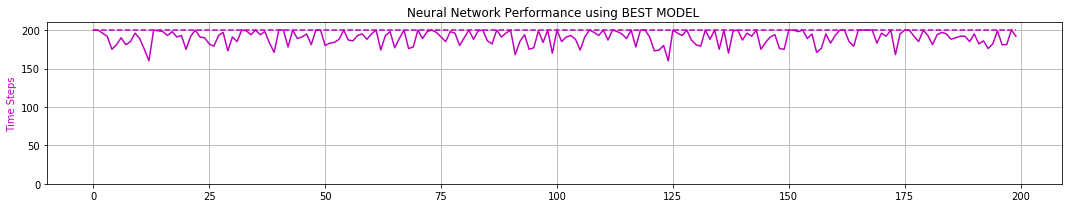

peak memory: 1372.66 MiB, increment: 1036.79 MiB
0 -max- [ 0.253  1.872  0.209  1.593]
0 -min- [-2.400 -2.463 -0.209 -2.454]

1 -max- [ 0.217  1.559  0.209  1.821]
1 -min- [-2.399 -2.448 -0.209 -2.465]

2 -max- [ 0.188  1.412  0.209  1.517]
2 -min- [-2.399 -2.577 -0.209 -2.452]

3 -max- [ 0.286  1.724  0.186  2.053]
3 -min- [-2.400 -3.025 -0.209 -2.293]

4 -max- [ 0.189  1.568  0.204  2.369]
4 -min- [-2.399 -3.185 -0.209 -2.339]

5 -max- [ 0.210  1.403  0.199  1.673]
5 -min- [-2.399 -2.852 -0.209 -2.303]

6 -max- [ 0.200  1.572  0.208  1.586]
6 -min- [-2.400 -2.758 -0.209 -2.549]

7 -max- [ 0.209  1.333  0.208  1.919]
7 -min- [-2.400 -2.646 -0.209 -2.245]

8 -max- [ 0.207  1.418  0.207  1.935]
8 -min- [-2.400 -2.672 -0.209 -2.218]

9 -max- [ 0.244  1.555  0.200  1.719]
9 -min- [-2.399 -2.588 -0.209 -2.603]

Quantization TIME:  0.02 minutes


ITERATION # 2
SMALLEST TIMESTEP in ITERATION 2: 10
REAL TIME TO GENERATE 68771 EXPERIENCES:0:00:01.752274


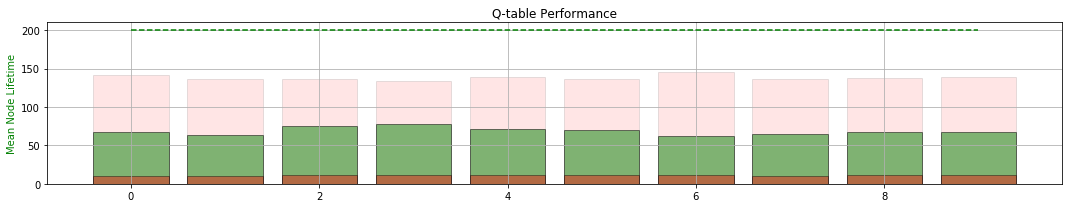

MEMORY COUNTER:  159802
Training Neural Network for 15000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.953	LOSS : 2.942	LOSS : 2.288	LOSS : 2.405	LOSS : 2.334	LOSS : 2.654	LOSS : 2.662	LOSS : 2.377	LOSS : 2.253	LOSS : 2.851	LOSS : 2.369	LOSS : 2.385	LOSS : 2.363	LOSS : 2.134	LOSS : 2.572	LOSS : 2.227	LOSS : 2.313	LOSS : 2.480	LOSS : 2.415	LOSS : 1.934	LOSS : 2.189	LOSS : 2.133	LOSS : 2.199	LOSS : 2.484	LOSS : 2.129	LOSS : 2.725	LOSS : 2.221	LOSS : 2.586	LOSS : 2.494	LOSS : 2.367	
Validating... MEAN TIME:  200.0
LOSS : 2.276	LOSS : 2.232	LOSS : 2.553	LOSS : 2.242	LOSS : 2.398	LOSS : 2.257	LOSS : 2.541	LOSS : 2.881	LOSS : 2.627	LOSS : 2.217	LOSS : 2.287	LOSS : 2.288	LOSS : 2.243	LOSS : 2.363	LOSS : 2.117	LOSS : 2.415	LOSS : 2.256	LOSS : 2.413	LOSS : 2.431	LOSS : 2.054	LOSS : 2.442	LOSS : 2.373	LOSS : 2.478	LOSS : 2.112	LOSS : 2.164	LOSS : 2.296	LOSS : 2.218	LOSS : 1.800	LOSS : 2.560	LOSS : 2.415	
Validating... MEAN TIME:  135.815
LOSS : 2.118	LOSS : 2.

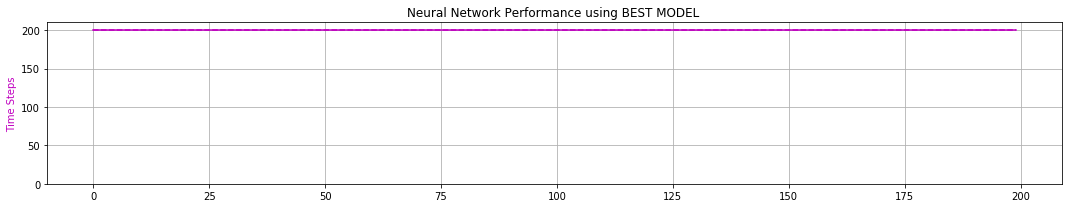

peak memory: 1407.18 MiB, increment: 1033.32 MiB
0 -max- [ 0.206  1.352  0.125  1.585]
0 -min- [-2.400 -2.761 -0.209 -1.972]

1 -max- [ 0.192  1.368  0.148  1.452]
1 -min- [-2.400 -2.791 -0.209 -1.960]

2 -max- [ 0.209  1.186  0.089  1.528]
2 -min- [-2.399 -2.809 -0.209 -1.840]

3 -max- [ 0.196  1.401  0.097  1.565]
3 -min- [-2.399 -2.470 -0.209 -1.961]

4 -max- [ 0.228  1.375  0.094  1.506]
4 -min- [-2.399 -2.648 -0.209 -1.976]

5 -max- [ 0.219  1.410  0.093  1.412]
5 -min- [-2.400 -2.631 -0.209 -1.980]

6 -max- [ 0.207  1.574  0.131  1.532]
6 -min- [-2.400 -2.657 -0.209 -2.371]

7 -max- [ 0.207  1.394  0.088  1.308]
7 -min- [-2.399 -2.424 -0.209 -1.985]

8 -max- [ 0.218  1.564  0.071  1.317]
8 -min- [-2.399 -2.634 -0.209 -2.293]

9 -max- [ 0.205  1.396  0.186  1.779]
9 -min- [-2.398 -2.662 -0.209 -2.029]

Quantization TIME:  0.02 minutes


ITERATION # 3
SMALLEST TIMESTEP in ITERATION 3: 11
REAL TIME TO GENERATE 82526 EXPERIENCES:0:00:02.083886


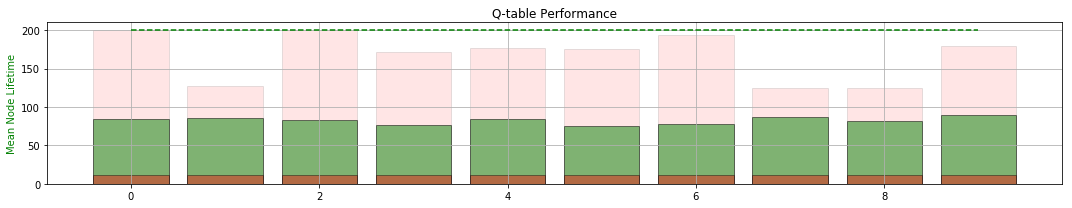

MEMORY COUNTER:  242328
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.790	LOSS : 1.705	LOSS : 2.283	LOSS : 2.410	LOSS : 2.245	LOSS : 1.748	LOSS : 1.805	LOSS : 2.003	LOSS : 2.164	LOSS : 1.943	LOSS : 1.817	LOSS : 2.080	LOSS : 1.801	LOSS : 2.032	LOSS : 2.198	LOSS : 1.939	LOSS : 1.608	LOSS : 2.233	LOSS : 2.003	LOSS : 1.962	LOSS : 1.970	LOSS : 1.649	LOSS : 1.906	LOSS : 2.027	LOSS : 1.792	LOSS : 2.127	LOSS : 1.810	LOSS : 2.057	LOSS : 2.101	LOSS : 2.228	
Validating... MEAN TIME:  149.01
LOSS : 1.642	LOSS : 2.247	LOSS : 1.819	LOSS : 2.058	LOSS : 1.984	LOSS : 2.311	LOSS : 1.777	LOSS : 2.381	LOSS : 2.169	LOSS : 2.299	LOSS : 1.880	LOSS : 1.895	LOSS : 2.137	LOSS : 1.847	LOSS : 2.180	LOSS : 1.905	LOSS : 1.830	LOSS : 2.150	LOSS : 1.961	LOSS : 1.895	LOSS : 1.878	LOSS : 2.246	LOSS : 1.679	LOSS : 1.980	LOSS : 2.315	LOSS : 2.065	LOSS : 1.942	LOSS : 2.357	LOSS : 2.189	LOSS : 1.864	
Validating... MEAN TIME:  147.1
LOSS : 2.071	LOSS : 2.12

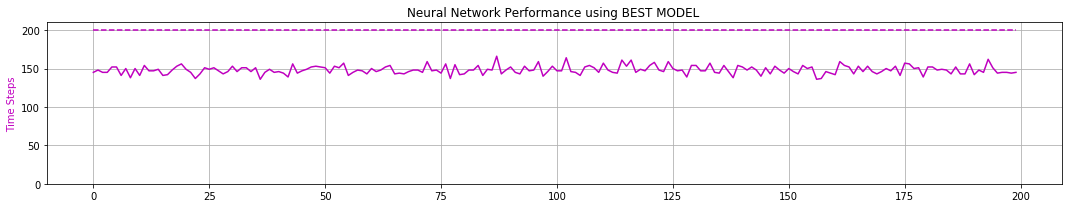

peak memory: 1412.96 MiB, increment: 1037.52 MiB
0 -max- [ 0.200  1.370  0.140  2.090]
0 -min- [-2.400 -2.388 -0.209 -1.992]

1 -max- [ 0.202  1.409  0.050  1.358]
1 -min- [-2.400 -2.426 -0.209 -1.997]

2 -max- [ 0.196  1.401  0.146  1.655]
2 -min- [-2.400 -2.424 -0.209 -1.961]

3 -max- [ 0.210  1.411  0.149  1.035]
3 -min- [-2.399 -2.435 -0.209 -1.995]

4 -max- [ 0.218  1.410  0.166  1.367]
4 -min- [-2.399 -2.431 -0.209 -1.982]

5 -max- [ 0.204  1.385  0.162  1.645]
5 -min- [-2.398 -2.367 -0.209 -2.072]

6 -max- [ 0.220  1.565  0.133  1.671]
6 -min- [-2.400 -2.421 -0.209 -2.308]

7 -max- [ 0.211  1.358  0.050  1.063]
7 -min- [-2.400 -2.246 -0.209 -1.993]

8 -max- [ 0.197  1.380  0.046  1.010]
8 -min- [-2.400 -2.395 -0.209 -1.996]

9 -max- [ 0.194  1.408  0.131  1.363]
9 -min- [-2.400 -2.406 -0.209 -2.006]

Quantization TIME:  0.01 minutes


ITERATION # 4
SMALLEST TIMESTEP in ITERATION 4: 50
REAL TIME TO GENERATE 173197 EXPERIENCES:0:00:04.943566


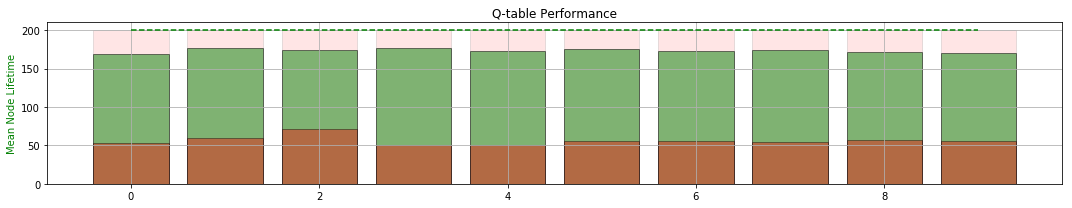

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.073	LOSS : 0.976	LOSS : 1.126	LOSS : 1.247	LOSS : 0.912	LOSS : 0.973	LOSS : 0.977	LOSS : 1.046	LOSS : 1.110	LOSS : 1.043	LOSS : 1.173	LOSS : 1.145	LOSS : 0.782	LOSS : 1.039	LOSS : 0.839	LOSS : 1.032	LOSS : 1.093	LOSS : 0.871	LOSS : 0.784	LOSS : 0.805	LOSS : 0.877	LOSS : 1.020	LOSS : 0.980	LOSS : 1.116	LOSS : 1.079	LOSS : 1.022	LOSS : 0.856	LOSS : 0.787	LOSS : 0.705	LOSS : 0.767	
Validating... MEAN TIME:  150.84
LOSS : 0.782	LOSS : 0.834	LOSS : 1.136	LOSS : 1.204	LOSS : 1.048	LOSS : 0.925	LOSS : 0.930	LOSS : 1.054	LOSS : 0.873	LOSS : 1.231	LOSS : 0.859	LOSS : 1.141	LOSS : 0.793	LOSS : 1.015	LOSS : 1.193	LOSS : 1.401	LOSS : 0.988	LOSS : 0.770	LOSS : 0.806	LOSS : 0.847	LOSS : 1.153	LOSS : 0.940	LOSS : 0.993	LOSS : 1.041	LOSS : 0.970	LOSS : 1.098	LOSS : 0.963	LOSS : 0.904	LOSS : 1.026	LOSS : 0.736	
Validating... MEAN TIME:  114.89
LOSS : 1.073	LOSS : 0.9

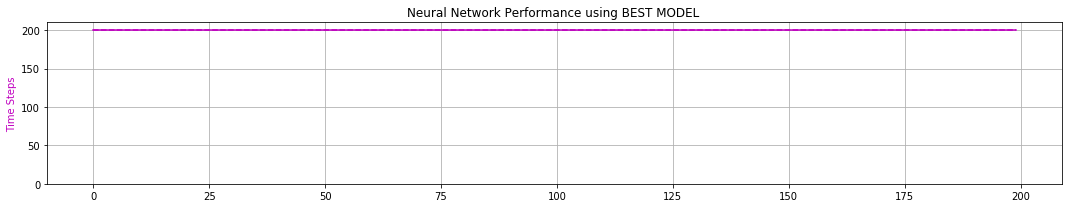

peak memory: 1462.49 MiB, increment: 1017.98 MiB
0 -max- [ 0.174  0.829  0.207  2.254]
0 -min- [-2.399 -2.198 -0.159 -1.541]

1 -max- [ 0.179  0.997  0.208  2.121]
1 -min- [-2.400 -2.172 -0.156 -1.806]

2 -max- [ 0.193  1.004  0.206  1.968]
2 -min- [-2.400 -2.196 -0.172 -1.527]

3 -max- [ 0.205  0.972  0.208  2.273]
3 -min- [-2.400 -2.242 -0.163 -1.697]

4 -max- [ 0.131  0.831  0.207  2.180]
4 -min- [-2.400 -2.232 -0.154 -1.683]

5 -max- [ 0.182  1.005  0.203  2.185]
5 -min- [-2.399 -2.354 -0.158 -1.801]

6 -max- [ 0.138  0.829  0.202  2.195]
6 -min- [-2.400 -2.418 -0.151 -1.680]

7 -max- [ 0.260  0.892  0.206  2.181]
7 -min- [-2.400 -2.206 -0.159 -1.565]

8 -max- [ 0.165  1.015  0.208  2.216]
8 -min- [-2.400 -2.169 -0.176 -1.799]

9 -max- [ 0.144  0.807  0.209  2.196]
9 -min- [-2.400 -2.209 -0.150 -1.692]

Quantization TIME:  0.02 minutes


ITERATION # 5
SMALLEST TIMESTEP in ITERATION 5: 10
REAL TIME TO GENERATE 124345 EXPERIENCES:0:00:03.230701


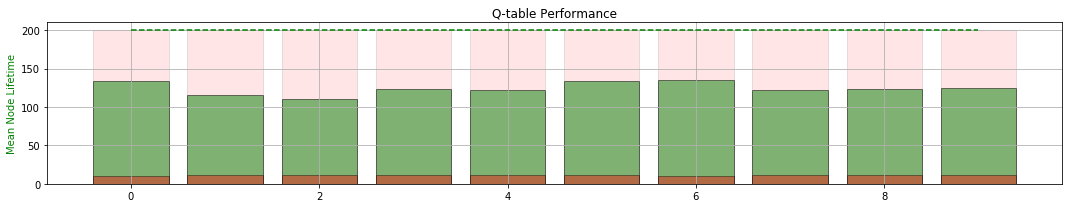

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 0.717	LOSS : 0.681	LOSS : 0.674	LOSS : 0.701	LOSS : 1.073	LOSS : 0.633	LOSS : 0.834	LOSS : 0.823	LOSS : 0.547	LOSS : 0.722	LOSS : 0.744	LOSS : 0.636	LOSS : 0.797	LOSS : 0.773	LOSS : 0.804	LOSS : 0.684	LOSS : 0.724	LOSS : 0.708	LOSS : 0.779	LOSS : 0.921	LOSS : 0.855	LOSS : 0.544	LOSS : 0.786	LOSS : 0.548	LOSS : 0.680	LOSS : 0.659	LOSS : 0.722	LOSS : 0.774	LOSS : 0.982	LOSS : 0.776	
Validating... MEAN TIME:  200.0
LOSS : 0.866	LOSS : 0.771	LOSS : 0.656	LOSS : 0.560	LOSS : 0.766	LOSS : 0.784	LOSS : 0.579	LOSS : 0.733	LOSS : 0.798	LOSS : 0.959	LOSS : 0.576	LOSS : 0.883	LOSS : 0.747	LOSS : 0.606	LOSS : 0.796	LOSS : 0.657	LOSS : 0.587	LOSS : 0.874	LOSS : 0.610	LOSS : 0.680	LOSS : 0.688	LOSS : 0.861	LOSS : 0.812	LOSS : 0.682	LOSS : 0.969	LOSS : 1.051	LOSS : 0.635	LOSS : 0.720	LOSS : 0.722	LOSS : 1.100	
Validating... MEAN TIME:  133.77
LOSS : 0.806	LOSS : 0.81

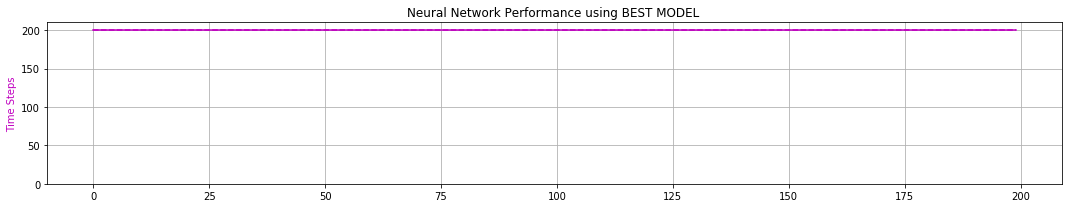

peak memory: 1455.99 MiB, increment: 1017.85 MiB
0 -max- [ 0.192  1.401  0.155  1.527]
0 -min- [-2.400 -2.208 -0.209 -2.112]

1 -max- [ 0.213  1.410  0.159  1.313]
1 -min- [-2.398 -2.210 -0.209 -1.995]

2 -max- [ 0.218  1.410  0.166  1.500]
2 -min- [-2.400 -2.220 -0.209 -1.982]

3 -max- [ 0.204  1.363  0.165  1.312]
3 -min- [-2.400 -2.239 -0.209 -1.959]

4 -max- [ 0.210  1.570  0.164  1.289]
4 -min- [-2.394 -2.221 -0.209 -2.294]

5 -max- [ 0.217  1.393  0.148  1.532]
5 -min- [-2.400 -2.214 -0.209 -1.993]

6 -max- [ 0.197  1.393  0.176  1.228]
6 -min- [-2.399 -2.221 -0.209 -1.996]

7 -max- [ 0.194  1.561  0.159  1.795]
7 -min- [-2.399 -2.215 -0.209 -2.302]

8 -max- [ 0.217  1.407  0.144  1.508]
8 -min- [-2.400 -2.225 -0.209 -2.045]

9 -max- [ 0.207  1.399  0.140  1.413]
9 -min- [-2.399 -2.585 -0.209 -1.986]

Quantization TIME:  0.01 minutes


ITERATION # 6
SMALLEST TIMESTEP in ITERATION 6: 16
REAL TIME TO GENERATE 155727 EXPERIENCES:0:00:04.634916


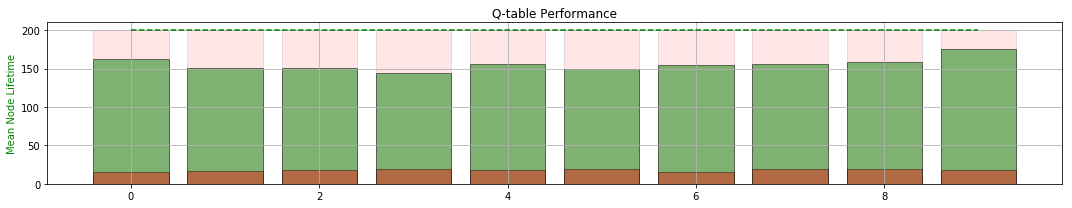

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 0.812	LOSS : 0.778	LOSS : 1.074	LOSS : 0.980	LOSS : 0.830	LOSS : 0.842	LOSS : 0.690	LOSS : 0.569	LOSS : 0.804	LOSS : 0.724	LOSS : 0.924	LOSS : 0.644	LOSS : 0.978	LOSS : 0.984	LOSS : 0.796	LOSS : 0.703	LOSS : 0.619	LOSS : 0.762	LOSS : 0.768	LOSS : 0.821	LOSS : 0.706	LOSS : 0.637	LOSS : 0.808	LOSS : 0.651	LOSS : 0.719	LOSS : 0.706	LOSS : 0.611	LOSS : 0.962	LOSS : 1.072	LOSS : 0.745	
Validating... MEAN TIME:  191.525
LOSS : 0.727	LOSS : 0.903	LOSS : 0.962	LOSS : 0.916	LOSS : 0.858	LOSS : 1.005	LOSS : 0.716	LOSS : 0.795	LOSS : 0.959	LOSS : 0.806	LOSS : 0.861	LOSS : 0.708	LOSS : 0.709	LOSS : 0.916	LOSS : 0.750	LOSS : 0.484	LOSS : 0.775	LOSS : 0.793	LOSS : 0.952	LOSS : 0.901	LOSS : 0.722	LOSS : 0.591	LOSS : 0.825	LOSS : 0.892	LOSS : 0.811	LOSS : 1.097	LOSS : 0.651	LOSS : 0.703	LOSS : 0.444	LOSS : 0.804	
Validating... MEAN TIME:  200.0
LOSS : 0.818	LOSS : 0.9

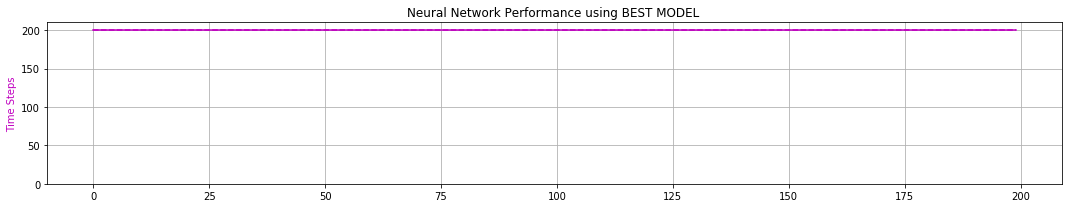

peak memory: 1428.84 MiB, increment: 1027.11 MiB
0 -max- [ 0.196  1.411  0.172  1.590]
0 -min- [-0.869 -1.533 -0.209 -1.980]

1 -max- [ 0.226  1.600  0.184  1.610]
1 -min- [-0.868 -1.536 -0.209 -2.239]

2 -max- [ 0.232  1.406  0.206  1.678]
2 -min- [-0.751 -1.673 -0.209 -1.958]

3 -max- [ 0.208  1.943  0.186  1.510]
3 -min- [-0.829 -1.380 -0.209 -2.287]

4 -max- [ 0.212  1.412  0.161  1.499]
4 -min- [-0.852 -1.526 -0.209 -1.978]

5 -max- [ 0.206  1.411  0.165  1.570]
5 -min- [-0.813 -1.538 -0.209 -1.982]

6 -max- [ 0.215  1.559  0.165  1.573]
6 -min- [-0.874 -1.525 -0.209 -2.284]

7 -max- [ 0.222  1.549  0.159  1.489]
7 -min- [-1.027 -1.500 -0.209 -2.178]

8 -max- [ 0.216  1.410  0.152  1.628]
8 -min- [-0.806 -1.518 -0.209 -1.993]

9 -max- [ 0.226  1.409  0.156  1.597]
9 -min- [-0.877 -1.386 -0.209 -1.979]

Quantization TIME:  0.01 minutes


ITERATION # 7
SMALLEST TIMESTEP in ITERATION 7: 200
REAL TIME TO GENERATE 200000 EXPERIENCES:0:00:06.929792


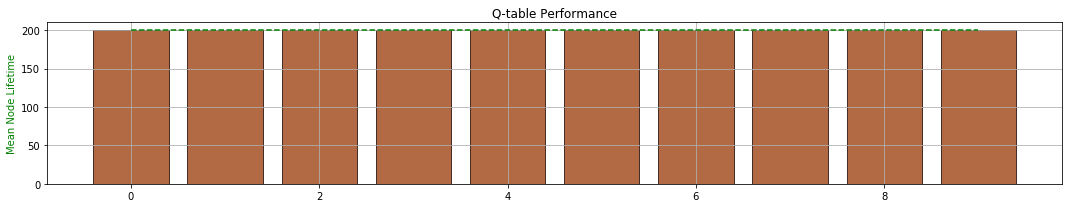

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)

    print("SMALLEST TIMESTEP in ITERATION {:d}: {:d}".format(iteration, node_time_rec.min().astype(int)))
    print("REAL TIME TO GENERATE {:d} EXPERIENCES:{}".format(EXP_GEN, (datetime.now()-tic)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_min_time.min() > 195:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    if iteration < 3:
        NN_LR = 1e-4
    else:
        NN_LR = 1e-3
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    print(int(BATCH_SIZE*TERMINAL_BIAS),"TERMINAL EXPERIENCES IN A BATCH SIZE OF",BATCH_SIZE)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, -1).astype(np.float16)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  1408.0
Total Serial Timesteps   :  895597.0
Speed-up                 :  636.08


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  3121 SUCCESS 200   7    1408     895597     636.08
